In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

In [14]:
df = pd.read_csv('ready_data2.csv')
df.drop(['row_id.2','row_id.1','row_id.3','customer_name.1','region.1'],axis=1,inplace=True)
df.set_index('row_id',inplace=True)
ret = pd.read_csv('../data/returns.csv')
df = pd.merge(left = ret, right = df, how = 'outer',left_on ='Order ID',right_on = 'order_id')
df.order_date = pd.to_datetime(df.order_date)
df.ship_date = pd.to_datetime(df.ship_date)
df.Returned = df.Returned.fillna(value='No')

C:\Users\Charlie\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Text(0.5, 1.0, 'Seasonal Changes in Inventory Quantities')

<Figure size 648x432 with 0 Axes>

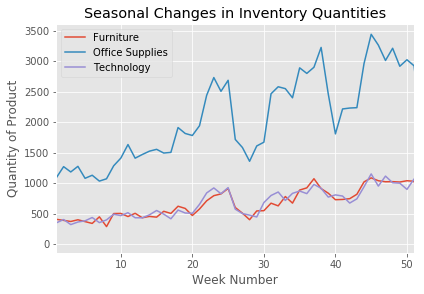

In [15]:
df2 = df[['quantity','order_date','category']]
df2.order_date = pd.to_datetime(df.order_date)
df2 = df2.groupby([df2.order_date.dt.strftime('%U'),df.category]).agg({'quantity':'sum'})

plt.figure(figsize=(9,6))
df2.unstack().plot(kind='line',stacked=False)
plt.xlabel('Week Number')
plt.ylabel('Quantity of Product')
plt.xlim(1,51)
plt.tight_layout()
plt.legend(['Furniture','Office Supplies','Technology'])
plt.grid(True)
#plt.xticks(np.arange(1,51,5))
plt.style.use('ggplot')
plt.title('Seasonal Changes in Inventory Quantities')

In [16]:
df[['Returned','profit','order_date','sales','order_id']].groupby(['order_id','Returned']).agg({'profit':'sum','sales':'sum'}).head()

,,profit,sales
order_id,Returned,,
AE-2012-PO8865138-41184,No,-246.08,161.08
AE-2014-EB4110138-41926,No,-236.96,229.00
AE-2014-MY7380138-42004,Yes,-38.07,23.64
AE-2015-GH4665138-42351,No,-429.10,281.51
AE-2015-JD5790138-42070,No,-11.57,6.43


In [17]:
df[['Returned','profit','order_date']].groupby([df.order_date.dt.strftime('%Y'),'Returned']).agg({'profit':'sum'})

profit
order_date Returned           
2012       No        231463.09
           Yes        17477.26
2013       No        298145.44
           Yes         9269.89
2014       No        389424.26
           Yes        17510.63
2015       No        487053.13
           Yes        17112.97

Text(0.5, 1.0, '1. Average Profit Loss by Returns')

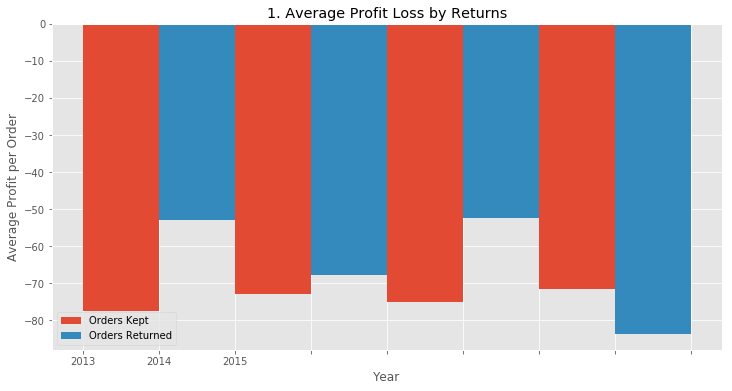

In [18]:
df3 = df
df3_1 = df3[df3.profit<0].groupby(['Returned',df3.order_date.dt.strftime('%Y')]).agg({'profit':'sum','order_id':'count'})

indices = range(len(df3_1.index.levels[1]))
names = df3_1.index.levels[1]
width = np.min(np.diff(indices)) / 2

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
df3_1 = df3_1.unstack(level=0)



ax.bar(indices - width / 2.,df3_1.profit.No.values/df3_1.order_id.No.values,width,label='Orders Kept')
ax.bar(indices + width / 2.,df3_1.profit.Yes.values/df3_1.order_id.Yes.values,width,label='Orders Returned')
ax.legend()
ax.axes.set_xticklabels(names)
plt.xlabel('Year')
plt.ylabel('Average Profit per Order')
plt.title('1. Average Profit Loss by Returns')

In [19]:
ret_customers = df3[df3.Returned == 'Yes'].customer_id.value_counts()
tot_customers = df3.customer_id.value_counts()

ret_customers[ret_customers.values > 5]

print('Out of {} customers, we have had {} customers return at least one order.'.format(len(tot_customers),len(ret_customers)))
print('We have had {} customers return more than five orders'.format(len(ret_customers[ret_customers.values > 5])))

Out of 17415 customers, we have had 1061 customers return at least one order.
We have had 46 customers return more than five orders


In [20]:
df3_3 = df3[['region','order_id','Returned']].groupby(['region','Returned']).agg({'order_id':'count'})
df3_3 = df3_3.unstack(level=-1)
df3_3 = df3_3.order_id.Yes / (df3_3.order_id.Yes + df3_3.order_id.No)
print('The countries most likely to return items are {}'.format(df3_3.sort_values().head(5).index.values))

The countries most likely to return items are ['Eastern Africa' 'Central Africa' 'Eastern Europe' 'Central US'
 'Northern Europe']


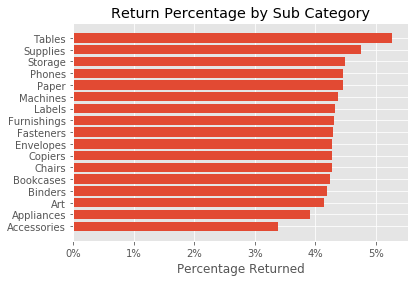

In [45]:
df3_4a = (
    df3
    [['category','sub_category','Returned','order_id']]
    .groupby(['Returned','category','sub_category'])
    .agg({'order_id':'count'})
    .unstack(level=0)    
)
df3_4a['perc'] = df3_4a.order_id.Yes / (df3_4a.order_id.No + df3_4a.order_id.Yes)
df3_4a.sort_values('perc',inplace=True)
names = df3_4a.index.levels[1].values
height = df3_4a.perc
y_pos = np.arange(len(names))
fig, ax = plt.subplots()
plt.barh(y_pos, height)#,color=height.index.levels[0].values)
plt.yticks(y_pos, names)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0,xmax=1))
plt.xlabel('Percentage Returned')
plt.title('Return Percentage by Sub Category')
plt.show()

In [30]:
height

category         sub_category
Office Supplies  Appliances      0.033869
                 Fasteners       0.039216
                 Envelopes       0.041475
                 Storage         0.041989
Technology       Machines        0.042396
Office Supplies  Supplies        0.042792
Furniture        Furnishings     0.042803
                 Chairs          0.042807
Office Supplies  Paper           0.042955
Furniture        Bookcases       0.043136
Technology       Phones          0.043193
Office Supplies  Binders         0.043768
Technology       Copiers         0.044534
Office Supplies  Art             0.044613
Technology       Accessories     0.044878
Furniture        Tables          0.047619
Office Supplies  Labels          0.052672
Name: perc, dtype: float64

In [10]:
df.Returned = pd.get_dummies(df.Returned,drop_first=True)
df['process_time'] = df.ship_date - df.order_date
df = df.join((df
         .groupby(['product_id']).agg({'Returned':'sum'})
         .sort_values('Returned')
         .rename(index=str,columns={'Returned':'times_returned'})
             ), on='product_id',how='left')

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [12]:
lg = LogisticRegression()
features = df[['process_time','times_returned']]
features['process_time'] = features['process_time'].astype('timedelta64[h]') / 24.
features['process_time'] = features['process_time'].astype(int)
target = df['Returned']
trainX,testX,trainY,testY = train_test_split(features, target, test_size = 0.8,random_state=42)
lg.fit(trainX, trainY)
lg.score(testX,testY)

C:\Users\Charlie\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Charlie\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Charlie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be cha

0.9528416845388965